In [7]:
import pandas as pd
import numpy as np
import re
import nltk
import joblib
import tensorflow as tf
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from google.colab import files
from csv import QUOTE_NONE


In [2]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [8]:
def preprocess_text(text):
    if pd.isnull(text):
        return ""
    text = text.lower()
    text = re.sub(r'[^a-zA-Z]', ' ', text)
    words = text.split()
    words = [word for word in words if word not in stop_words]
    return ' '.join(words)

In [9]:
df = None
uploaded = files.upload()
for file_name in uploaded.keys():
    file_path = f'/content/{file_name}'
    df = pd.read_csv(file_path, quoting=QUOTE_NONE, encoding='utf-8', on_bad_lines='skip')
    break

Saving reviews.csv to reviews (1).csv


In [10]:
df['Processed_Review'] = df['Review'].astype(str).apply(preprocess_text)

In [11]:
tfidf = TfidfVectorizer(max_features=5000)
X = tfidf.fit_transform(df['Processed_Review']).toarray()
y = df['Label']

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [13]:
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [14]:
y_pred = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.7908324552160169
Classification Report:
               precision    recall  f1-score   support

           1       0.55      0.24      0.33       208
           2       0.33      0.02      0.04       196
           3       0.33      0.04      0.07       442
           4       0.40      0.09      0.15      2027
           5       0.81      0.98      0.89     10413

    accuracy                           0.79     13286
   macro avg       0.48      0.27      0.30     13286
weighted avg       0.72      0.79      0.73     13286



In [15]:
joblib.dump(model, 'recommendation_model.pkl')
joblib.dump(tfidf, 'tfidf_vectorizer.pkl')

['tfidf_vectorizer.pkl']

In [16]:
files.download('recommendation_model.pkl')
files.download('tfidf_vectorizer.pkl')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

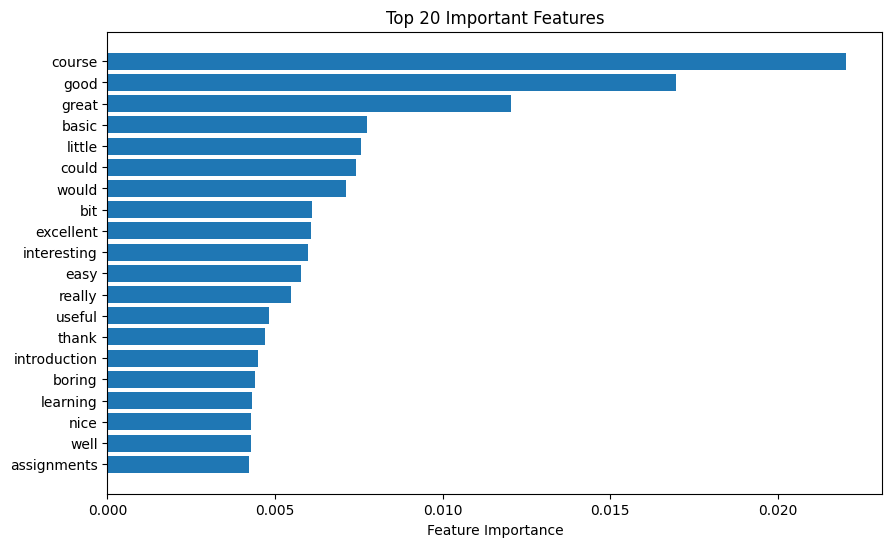

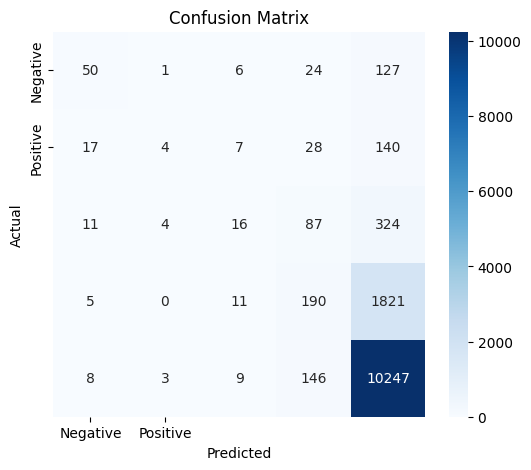

ValueError: multiclass format is not supported

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc

feature_importance = model.feature_importances_
indices = np.argsort(feature_importance)[-20:]

plt.figure(figsize=(10, 6))
plt.title("Top 20 Important Features")
plt.barh(range(len(indices)), feature_importance[indices], align="center")
plt.yticks(range(len(indices)), np.array(tfidf.get_feature_names_out())[indices])
plt.xlabel("Feature Importance")
plt.show()


y_pred = model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title("Confusion Matrix")
plt.show()

y_pred_proba = model.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='grey', linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.show()
